<a href="https://colab.research.google.com/github/Rishav273/whj-text-classifier/blob/main/Whitehat_R3_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Machine Learning:

#### Machine Learning is a form of artificial intelligence where algorithms are trained on lots of data to answer some question or provide some response. At the heart of machine learning lies the fundamental prblem of "prediction", i.e. predicting some value based on data provided to the algorithm/model as inputs.

#### Predictive problems are mainly 2 fold. 

* regression problems - > These are problems where the machine learning model predicts a continuous value as its response. eg: Car price, people's height,weight etc.

* classification problems -> In these problems the model predict classes or categories, which are denoted by discrete values. eg: whether a child wants to play cricket or doesn't (denoted by the discrete values of 0 and 1 respectively). There can be more than 2 categories as well, eg: the weather is sunny, rainy or snowy.

#### In this notebook we will explore a binary classsification machine learning problem, which means that the model that we build takes in some data as input and outputs either of "two"  categories. Obviously, to create a model, we require data. MOre information abt the dataset is provided below.  



## Gender Classification task:

In this notebook we are going to explore datasets that contain information about hollywood movies and metainformation about the corresponding characters in the movie. 
The usecase is to build an gender classifier model that takes in movie dialogues as input and predicts whether the dialogue was spoken by a male or female.  

## More information about the dataset:
This corpus contains a metadata-rich collection of fictional conversations extracted from raw movie scripts:

220,579 conversational exchanges between 10,292 pairs of movie characters
involves 9,035 characters from 617 movies
in total 304,713 utterances
movie metadata included:
* genres
* release year
* IMDB rating
* number of IMDB votes
* IMDB rating

moviecharactersmetadata.txt

contains information about each movie character
fields:
* characterID
* character name
* movieID
* movie title
* gender ("?" for unlabeled cases)
* position in credits ("?" for unlabeled cases)

movie_lines.txt
fields:
* lineID
* characterID (who uttered this phrase)
* movieID
* character name
* text of the utterance

movie_conversations.txt

the structure of the conversations
fields
* characterID of the first character involved in the
conversation
* characterID of the second character involved in the conversation
* movieID of the movie in which the conversation occurred
* list of the utterances that make the conversation, in chronological
order: ['lineID1','lineID2',É,'lineIDN']
has to be matched with movie_lines.txt to reconstruct the actual content

rawscripturls.txt

the urls from which the raw sources were retrieved

### let us unzip the dataset we will use. It is kept in my own google drive and hence I'll be providing the path to the dataset. We will unzip using the !unzip command. "!" command denotes shell commands in colab. 

In [2]:
# Let us unzip the dataset we will use.

!unzip /content/drive/MyDrive/movie_dialogue_dataset.zip

Archive:  /content/drive/MyDrive/movie_dialogue_dataset.zip
  inflating: README.txt              
  inflating: movie_characters_metadata.tsv  
  inflating: movie_conversations.tsv  
  inflating: movie_lines.tsv         
  inflating: movie_titles_metadata.tsv  
  inflating: raw_script_urls.tsv     


#### let us examine each of the datasets in further detail. We will be importing the required python modules for this usecase below.

#### We will use pandas for analysing our data, through pandas Dataframe objects. Matplotlib and seaborn will be used as visualisation tools. NLTK will be our text preprocessing library.  We will also import Scikit-learn package for using machine learning models.   

In [3]:
import numpy as np  # library for scientific computing
import pandas as pd # we will use pandas for analysing our data.
import matplotlib.pyplot as plt # matplotlib is a data visualization package 
import seaborn as sns # seaborn is a data visualisation library built on top of matplotlib
from nltk.stem import WordNetLemmatizer   # nltk is a library used for text processing
import re   # regular expressions module ffor filtering out unneeded textstrings

#### note: All the files are in tsv (tab separated value) format. hence we will use the pandas read_csv() method and use '\t' (denoting tabs) as separator argument for the files.
#### Also, the data contains certain rows where the schema is not followed (incorrect number of columns in a certain row).

#### We will set the "error_bad_lines" argument in the read_csv function to false, which will skip those lines.  

#### We load each of the files into their corresponding variables below. 

In [4]:
def read_data(data_path, names, sep = "\t"):

  """
  This function takes in a data path as input and outputs a pandas dataframe. 
  """

  df = pd.read_csv(data_path,names=names,sep=sep,error_bad_lines=False, header=None)
  return df

In [5]:
# store the paths of each file to a variable. We don't need to copy paste the paths everytime.  
char_path = "/content/movie_characters_metadata.tsv"
conv_path = "/content/movie_conversations.tsv"
lines_path = "/content/movie_lines.tsv"
titles_path = "/content/movie_titles_metadata.tsv"
script_path = "/content/raw_script_urls.tsv"

char_df = read_data(char_path,names=['char_id','char_name','movie_id','movie_name','gender','post_credits'])  # characters dataset
conv_df = read_data(conv_path,names=['char1_id','char2_id','movie_id','utterances'])  # conversations dataset
lines_df = read_data(lines_path,names=['line_id','char_id','movie_id','char_name','dialogue'])   # lines dataset
titles_df = read_data(titles_path,names=['movie_id','movie_name','release_year','rating','votes','genre'])  # movie titles dataset

### Let us now look at each of the loaded dataframes in detail.

#### We notice that the common column (a.k.a primary key) in all these dataframes is the movie_id. There is also the char_id which is unique for each character. These will come in handy after we inspect the dataframes, when we will merge them for our usecase. 

In [6]:
dataframes = [char_df,conv_df,lines_df,titles_df]   # create list of the dataframes. 

for dataframe in dataframes:    # iterate over the list and print the column names of each dataframe in the list 
  print(dataframe.columns,sep="\n") # printing columns of each dataframe on a new line 

Index(['char_id', 'char_name', 'movie_id', 'movie_name', 'gender',
       'post_credits'],
      dtype='object')
Index(['char1_id', 'char2_id', 'movie_id', 'utterances'], dtype='object')
Index(['line_id', 'char_id', 'movie_id', 'char_name', 'dialogue'], dtype='object')
Index(['movie_id', 'movie_name', 'release_year', 'rating', 'votes', 'genre'], dtype='object')


# We will use the head(n) method to display the first "n" rows of the dataset. This helps us get a better idea about the items we need to work with.

In [7]:
# using the head(n) method to inspect the first n rows of the dataset 
char_df.head(3)

,char_id,char_name,movie_id,movie_name,gender,post_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3


In [8]:
lines_df.head(3)

,line_id,char_id,movie_id,char_name,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.


In [9]:
titles_df.head(3)

,movie_id,movie_name,release_year,rating,votes,genre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']


##### We observe that lines_df contains the dialogues and char_df contains info about character names and genders. We also have titles_df which contains info about movie ratings, votes and genre. Hence the info we need for our usecase is constrained in lines_df and char_df dataframes. We will examine these in more detail.

In [10]:
conv_df.head(3)

,char1_id,char2_id,movie_id,utterances
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']


#### We can use the info() method to show us a concise summary of the data with the number of rows, column and the data type of each column (Dtype). We also find out how many null values are contained in each column in the non null count section.   

In [11]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   char_id       9035 non-null   object
 1   char_name     9016 non-null   object
 2   movie_id      9017 non-null   object
 3   movie_name    9017 non-null   object
 4   gender        9017 non-null   object
 5   post_credits  9017 non-null   object
dtypes: object(6)
memory usage: 423.6+ KB


#### The char_df dataframe contains the gender column which we will be using. It would be a good idea to look at the frequency of unique values in that column. We do this by using the value_counts() method which shows us those details. Any column i a dataframe is chosen by the df_name[column_name] code. In our case it is char_df["gender"]. Then the value_counts() method is used on it.

In [12]:
char_df["gender"].value_counts()

?    6008
m    1899
f     921
M     145
F      44
Name: gender, dtype: int64

#### As we can see, there is a large proportion of the messages with the value "?". There are other values which can be aggregated together like "m" and "M", "f" and "F" can be considered as one group. NOrmally, these rows needed to be imputed manually by looking at the corresponding character names and imputing them. 

#### Imputation just means "filling unwanted values with meaningful values". There are many approaches to do this such as using the mode (most frequent value) of the column to impute, or even using a distance based algorithm like KNN for imputation. But for our usecase none of those will be meaningful changes.  

#### We can check the corresponding character names using the code below. THis is a filtering step in pandas, where we only select rows where gender (or any ther column) has some specific value (in this case "?").

In [13]:
char_df[char_df["gender"] == "?"]["char_name"]

1               BRUCE
3            CHASTITY
8          MISS PERKY
10             SHARON
12             ALONSO
            ...      
9030         DURNFORD
9031          MELVILL
9032    NORRIS-NEWMAN
9033     STUART SMITH
9034          VEREKER
Name: char_name, Length: 6008, dtype: object

#### Manually imputing 6000 rows of data is a tedious task and we want to keep things simple for now. Hence we will be dropping these rows, at the cost of data loss. We also need to encode the values "M" and "F" to numbers, since algorithms only work with numbers. We will use 0 to denote male characters and 1 to denote female characters.


#### We filter out the rows where gender value is marked as "?". In the next line we use the apply() method and a lambda function to encode the letters to numbers.

In [14]:
# Only select those enteries where gender is not labelled as "?"
char_df = char_df[char_df["gender"] != "?"]

# encode males as 0 and females as 1
char_df["gender"] = char_df["gender"].apply(lambda x: 0 if x in ["m","M"] else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### We can check the shape off our resultant dataframe with the shape() method. We can see that "?" values were dropped and we are left with 3027 rows in the char_df 

In [15]:
char_df.shape

(3027, 6)

# Data Visualisation: A visual approach to gaining data insights.  

#### Our eyes and brain are much more equipped to understand visual messages than numbers. So it is better that we use some data visualisation tools to gain deeper insight about our dataset.

#### Pyhton has matplotlib and seaborn, which are 2 popular packages used for data visualisation.


#### A fundamental rule of visualisation is to keep things as simple as possible. The goal is not to make the visualisations beautiful, but to make them meaningful enough to easily infer the insights from it.


#### We will make extensive use of the barplot which is a really good way of plotting numeric and categorical variables.

#### First let us see how many characters there are in each gender.

### We can use pandas internal plotting library, and a barplot to visualize the number of instances in each class (i.e. male or female). This is done by using the sns.barplot() method which takes in the categories as x coordinate and the counts as the y coordinate. 

#### kind argument denotes the kind of plot. WE have selected "bar". figsize denotes the size of the figure and it takes a tuple of values -> (width,height). The title takes the heading of the plot. The xlabel takes in the value used for the x coordinate. plt.show() method is used to show the plot, although it is optional in a jupyter-notebook like enviroment.

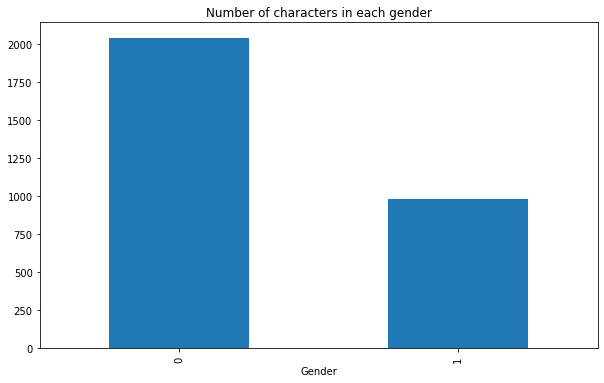

In [16]:
char_df["gender"].value_counts().plot(kind="bar",
                                      figsize=(10,6),
                                      xlabel="Gender",
                                      title="Number of characters in each gender")
plt.show()      # show the plot

#### In the above diagram, we can infer that there is a significantly large proportion of male characters than female in the movies. 

#### it might also be a good idea to merge the titles_df and lines_df together, since titles_df contains useful info about the movies. We will do that using pd.merge() function and join on the movie_id and movie_name columns. The "inner" argument only selects only those keys that intersect in both dataframes. We save the merged dataframe into a new variable called temp_df  

In [17]:
temp_df = pd.merge(char_df,titles_df,how="inner",on=["movie_id","movie_name"]) # pd.merge() method on movie_id  key
temp_df.head(3)

,char_id,char_name,movie_id,movie_name,gender,post_credits,release_year,rating,votes,genre
0,u0,BIANCA,m0,10 things i hate about you,1,4,1999,6.9,62847.0,['comedy' 'romance']
1,u2,CAMERON,m0,10 things i hate about you,0,3,1999,6.9,62847.0,['comedy' 'romance']
2,u4,JOEY,m0,10 things i hate about you,0,6,1999,6.9,62847.0,['comedy' 'romance']


In [18]:
# The code below uses .describe() generates some descriptive statistics about the release_year column, like counts, no. of unique values etc
temp_df["release_year"].describe()

count     3009
unique      88
top       1999
freq       237
Name: release_year, dtype: object

#### Let us look at the release_year column. When we are dealing with object data types (data types which are passed as string values) we should alaways check the nuber of unique values it contains. This igves us info about possible bugs or chunks inside the values that may later create problems in our analysis.    

#### Using the unique() method on the release year column, We can see below that some of the years have been encoded differently, with escape characters being included in the string. This will invariably cause problems later on, so We will deal with that.

In [19]:
temp_df["release_year"].unique()

array(['1999', '1992', '2001', '1968', '1982', '1997', '1988', '1989',
       '1959', '1980', '1986', '1984', '1981', '1932', '2000', '1998',
       '1991', '1975', '2003', '2006', '1989/I', '1996', '2004', '1995',
       '1942', '1974', '1990', '1933', '1993', '2005', '1931', '2009',
       '2002', '1967', '1971', '1979', '1987', '1940', '1961', '2007',
       '1953', '1934', '1990/I', '1983', '1994', '1985', '1976', '1937',
       '1955', '1970', '1941', '1927', '1939', '1936', '1995/I', '1954',
       '1949', '1943', '2010', '1977', '1972', '1963', '1945', '2008',
       '1960', '1964', '1950', '1973', '1998/I', '1966', '2004/I',
       '2007/I', '1944', '1978', '1992/I', '2005/I', '2002/I', '1946',
       '1969', '1965', '1968/I', '1996/I', '1956', '1957', '2000/I',
       '2009/I', '1958', '2003/I'], dtype=object)

#### We use the str.replace() method to replace any substrings with our desired string. below, we have replaced "/I" with blank strings "".

In [20]:
# replace all escape characters and uppercase I with blanks
temp_df["release_year"] = temp_df["release_year"].str.replace("/I","")

#### The resultant column has been cleaned, as you can see below. 

In [21]:
temp_df["release_year"].unique()

array(['1999', '1992', '2001', '1968', '1982', '1997', '1988', '1989',
       '1959', '1980', '1986', '1984', '1981', '1932', '2000', '1998',
       '1991', '1975', '2003', '2006', '1996', '2004', '1995', '1942',
       '1974', '1990', '1933', '1993', '2005', '1931', '2009', '2002',
       '1967', '1971', '1979', '1987', '1940', '1961', '2007', '1953',
       '1934', '1983', '1994', '1985', '1976', '1937', '1955', '1970',
       '1941', '1927', '1939', '1936', '1954', '1949', '1943', '2010',
       '1977', '1972', '1963', '1945', '2008', '1960', '1964', '1950',
       '1973', '1966', '1944', '1978', '1946', '1969', '1965', '1956',
       '1957', '1958'], dtype=object)

#### The figure below shows the maximum votes given to movies for every year from 1927-2010. We do this by using the df.groupby() function for aggregating the votes using release_year. the plot is made using pandas internal plotting library.

#### note: groupby() is an extremely useful method for aggregating our desired data based on specific columns. The column levels will be passed in as an argument to the method and then we can call any numerical aggregation (in the form of counts, mean, median, etc) on the columns that we desire.

#### We check the maximum votes given to a movie each year using the groupby() method below. We also use sort_values() to the result to sort them in ascending order.


#### We can see that 1972 had the maximum amount of votes give by audiences to movies

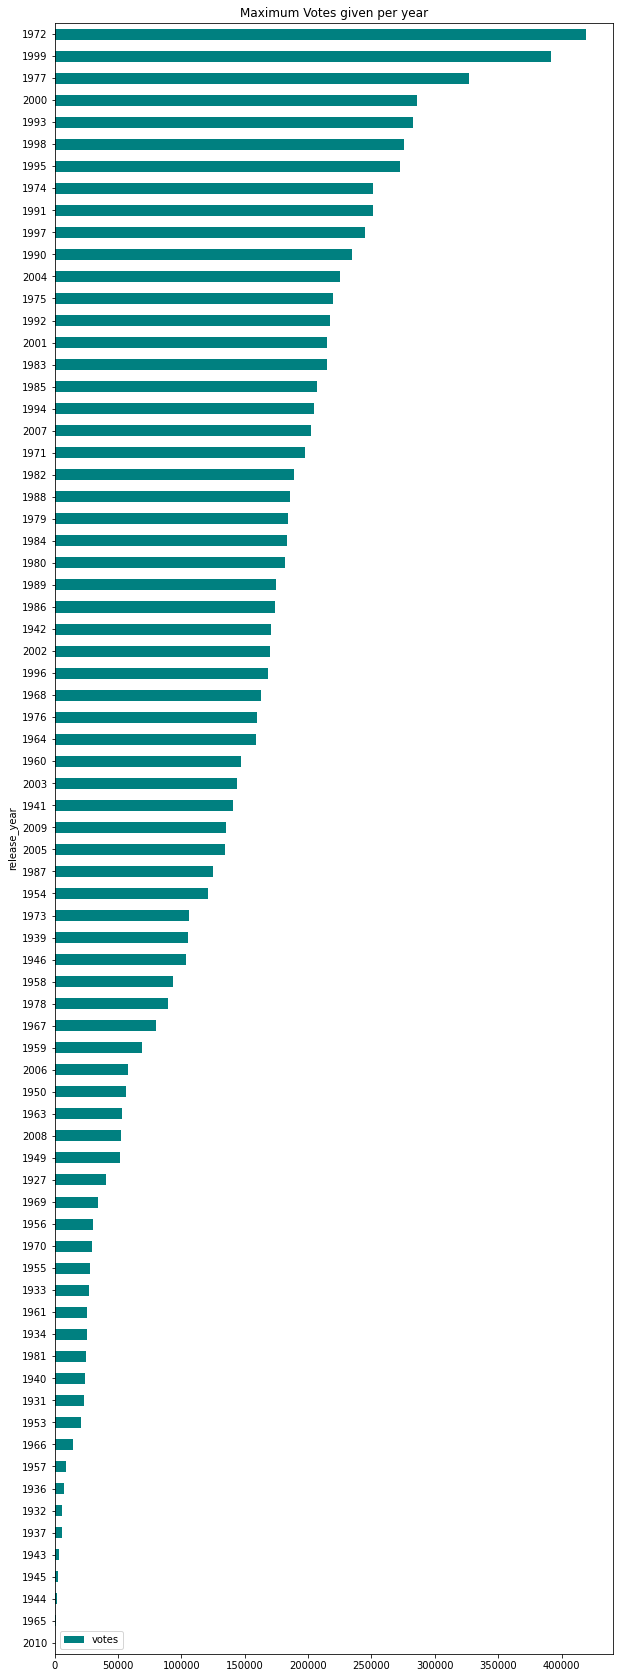

In [22]:
# groupby release year, aggregate maximum votes given
pd.DataFrame(temp_df.groupby("release_year")["votes"].max().sort_values()).plot(kind="barh",
                                                                  figsize=(10,30),
                                                                  color="teal",
                                                                  title="Maximum Votes given per year")
plt.show()  

#### Below you can see the 5 highest rated movie genres. Unsurprisingly it is populated with "action","adventure","crime" etc since these are the most consumed genres in the mainstream movie industry.

#### We are grouping by the genre and aggregating the ratings with the maximum values, then sorting them in descending order (sor_values(ascending=False) and displaying the top 5 values with .head().

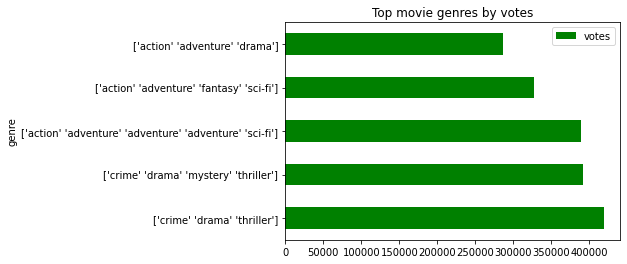

In [23]:
# Display the top 5 highest rated movie genres
pd.DataFrame(temp_df.groupby("genre")["votes"].max().sort_values(ascending=False).head()).plot(kind="barh",
                                                                                               color="green",
                                                                                               title="Top movie genres by votes")
plt.show() 

#### The barplot below represents the highest rated movies in the dataset. We are grouping by "movie_name", aggregating by the maximum rating values (.max()), and showing the top 5 results

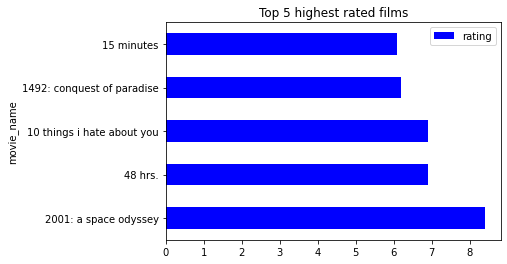

In [24]:
pd.DataFrame(temp_df.groupby(["movie_name"])["rating"].max().head().sort_values(ascending=False)).plot(kind="barh",
                                                                                                       color="blue",
                                                                                                       title="Top 5 highest rated films")
plt.show()

In [25]:
char_df.head()

,char_id,char_name,movie_id,movie_name,gender,post_credits
0,u0,BIANCA,m0,10 things i hate about you,1,4
2,u2,CAMERON,m0,10 things i hate about you,0,3
4,u4,JOEY,m0,10 things i hate about you,0,6
5,u5,KAT,m0,10 things i hate about you,1,2
6,u6,MANDELLA,m0,10 things i hate about you,1,7


### Let us now examine the lines_df dataframe:

#### The most important feature of this dataset is "dialogue". The others are either primary keys (like movie_id, line_id and char_id) or they hold redundant information in this context (like char_names). The dataset also contains missing values which will be dealth with later. 

In [26]:
lines_df.head(3) # head method to inspect few rows of the dataset

,line_id,char_id,movie_id,char_name,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.


In [27]:
lines_df.info() # general summary of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293368 entries, 0 to 293367
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   line_id    293368 non-null  object
 1   char_id    289083 non-null  object
 2   movie_id   289083 non-null  object
 3   char_name  289040 non-null  object
 4   dialogue   288823 non-null  object
dtypes: object(5)
memory usage: 11.2+ MB


#### We will now be merging the lines_df dataframe with the char_df dataframe. The merge() method takes in 2 dataframes and aggregates their information. It does so by merging the dataframes on common columns, also called primary keys, using the "on" argument.

In [28]:
# merge lines_df and char_df into one dataframe
data = pd.merge(lines_df,char_df,how="inner",on=["char_id","movie_id","char_name"])

# print first 5 rows
data.head()

,line_id,char_id,movie_id,char_name,dialogue,movie_name,gender,post_credits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,1,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,1,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,1,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,1,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,1,4


### We will now check for missing or null values in any of the column in the dataset. Dealing with missing values is a necessary preprocessing step in order to work with Machine Learning models.
### We will use the data.isnull().sum() method to find out how many null values are present in each column.

In [29]:
data.isnull().sum()

line_id           0
char_id           0
movie_id          0
char_name         0
dialogue        203
movie_name        0
gender            0
post_credits      0
dtype: int64

### On closer inspection we can see that only the dialogue column contains null_values. Since dialogues are arbitrary and there really isn't any way to impute them, we drop these columns.

### We will then remove missing values from the dataset using the dropna() method. 

In [30]:
data = data.dropna()

### Checking once again, we can see that all the null values have been removed from the dataset.

In [31]:
data.isnull().sum()

line_id         0
char_id         0
movie_id        0
char_name       0
dialogue        0
movie_name      0
gender          0
post_credits    0
dtype: int64

#### Let us now clean the dialogues. There are a few fundamental concepts to keep in mind here.

#### Machine Learning algorithms and predictive models cannot work with unstructured data like images or raw text. They can only work with numbers. Hence it is our job to transform our the datasets such that it can be understood by the algorithms. 

#### Text strings (like the ones in the dialogue column) need to be numerical encoded into numbers (or tokenized) to achieve this. One approach of doing so is converting each individual word in the string to corresponding tokens. The aim is to create a vocabulary of unique words that were learned in the training data, which will be used later to make predictions on unseen test data. But before that, we need to clean the strings.


#### The predictive strength of our classification model will depend on what sort of data is passed to it, and how the text data has been encoded. We can choose to remove punctuations, since they add extra noise. We can choose to convert the words to lowercase, or remove commonly used words which really don't add any value to the sentence. (a.k.a stopwords -> eg: I, a, the, are, is, he, she etc). There are multiple ways to approach the problem, and the correct one is guided by the problem we are trying to solve.




### Let us check the words that occur the most across all the individual dialogues in the dataset. We import the WordCloud class from the wordcloud library. wordcloud illustrates the most common word occurences in a corpus or text.

### In this case, we create an object of the WordCloud class, generate the words from the "dialogue" column using "word_cloud.generate(" ".join(data["dialogue"]))". Then we illustrate the words using "imshow()" function of matplotlib.  

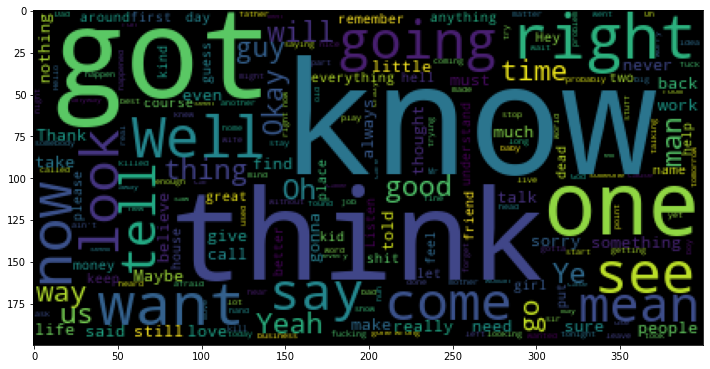

In [32]:
from wordcloud import WordCloud   # imprt wordcloud

word_cloud = WordCloud()    # create WordCloud object 
word_cloud.generate(" ".join(data["dialogue"]))   # generate words from the dialogue column
plt.figure(figsize=(12,18)) 
plt.imshow(word_cloud)  # illustrate common words

### We learnt earlier that stopwords carry very little information in a corpus and its better to avoid it. But in some cases (like this one), words like (the, a,and, you, are, is) provide useful contextual information, which might be useful for the model when it is learning from the data. Hence we will not be removing these words.

### However, it is better that filter out things in such a way that the dialogue only contains alphanumeric characters. We also get rid of punctuations.


### We do these steps in a function called clean_dialogues(), as shown below.

* First we remove html tags and punctuations using regular expressions. We only keep letters in the string.

* Then, we convert each word to lower case and use split() funtion to convert to individual words.

* Next we use a lemmatizer, which takes in an input word and converts it to its base or root word. (eg: converts words like "went", "gone", "going", to "go" which is the base for all these words). This reduces the size of the vocabulary as well, which in turn reduces computational cost. 

### It would be useful to import the nltk library and run the command "nltk.download('wordnet')", which downloads the wordnet dictionary. This is necessary for our lemmatizer to work properly and not generate any errors.   

In [33]:
import nltk   # import nltk
nltk.download('wordnet')   # download the wordnet corpus from nltk

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [34]:
lemmatizer = WordNetLemmatizer()    # instantiating an object of the WordNetLemmatizer class

In [35]:
def clean_dialogues(dialogue):

  """
  Function that takes in a dialogue as input and outpus an alphanumeric corpus of text.
  """ 

  dialogue = re.sub("[^a-zA-Z]", " ", dialogue)   # filter out characters such that only alphanumeric characters remain

  dialogue = dialogue.lower().split()    # convert words to lowercase and split string to individual words

  clean_dialogue = [lemmatizer.lemmatize(word) for word in dialogue]   # lemmatize each word in the dialogue and create a list of 
                                                                        # clean words

  return " ".join(clean_dialogue)   # return the clean words from the list in a single text


### Now we will apply this clean_dialogues() function on the dialogue column using the apply() method

In [36]:
data["dialogue"] = data["dialogue"].apply(clean_dialogues)

### We now have a cleaned dataset that can be used for feature selection. 

In [37]:
data.head()

,line_id,char_id,movie_id,char_name,dialogue,movie_name,gender,post_credits
0,L1045,u0,m0,BIANCA,they do not,10 things i hate about you,1,4
1,L985,u0,m0,BIANCA,i hope so,10 things i hate about you,1,4
2,L925,u0,m0,BIANCA,let s go,10 things i hate about you,1,4
3,L872,u0,m0,BIANCA,okay you re gonna need to learn how to lie,10 things i hate about you,1,4
4,L869,u0,m0,BIANCA,like my fear of wearing pastel,10 things i hate about you,1,4


#### from the dataframe we can see that each character has multiple dialogues in a film. What we need to do is groupby the character names and gender, and concatenate all dialogues stated by an individual character into a single string. We do this by using the .groupby() function once again. and aggregating the dialogues. 

#### We execute all the mentioned steps below, and assign to a variable called final_df  

In [38]:
final_df = data.groupby(["char_name","gender"]).agg({"dialogue":[lambda words: " ".join(words)]})   # groupby character names and gender,
                                                                                                    # aggregate dialogue of each character into
                                                                                                    # one string
final_df.head(3)

,,dialogue
,,<lambda>
char_name,gender,
AARON,0,why congratulation on history s longest winnin...
AARONOW,0,if anyone s going i could use some coffee fine...
ABBOTT,0,he left yesterday on the night train he s prob...


#### We then reset the index using the reset_index() function. This will use the default integers indices, and the previous ones will be converted to column and added to the data. Hence, char_name and gender will be converted to their own column in this dataframe.

In [39]:
final_df = final_df.reset_index()     # reset the index of the dataframe. 
                                      #The previous indices of char_name and gender get converted to column and added.
final_df.head(3)

,char_name,gender,dialogue
,,,<lambda>
0,AARON,0,why congratulation on history s longest winnin...
1,AARONOW,0,if anyone s going i could use some coffee fine...
2,ABBOTT,0,he left yesterday on the night train he s prob...


#### Finally we create a list denoting the column names to use, and assign them to final_df.columns

In [40]:
columns_to_use = ["char_name","gender","dialogue"]    # create list of columns to use
final_df.columns = columns_to_use     # use the columns

In [41]:
final_df.head(3)

,char_name,gender,dialogue
0,AARON,0,why congratulation on history s longest winnin...
1,AARONOW,0,if anyone s going i could use some coffee fine...
2,ABBOTT,0,he left yesterday on the night train he s prob...


In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   char_name  1955 non-null   object
 1   gender     1955 non-null   int64 
 2   dialogue   1955 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.9+ KB


#### Before we move on, let us create our training and test datasets. Our models will be trained on the training set and then will be used to make predictions on the test set.

#### First we will separate our predictor set (inputs) and our reponse set (outputs). For our usecase, the predictor will be the dialogue spoken by a character and the output will be the gender of that character. We will store them in variables X and y respectively.  

In [43]:
X = final_df["dialogue"]    # assign input dialogues to a variable X, which denote our predictors

y = final_df["gender"]   # We will be using the genders as our response. 

In [44]:
X.shape

(1955,)

#### Now let us partition our training and test sets. We will use the scikit-learn train_test_split() function to achieve this. We import it first and then use it to create the partitions. 

#### The test_size argument refers to the proportion of your test partition. In our case it's better to have test_data  20% of our overall data. so it will be 0.2

#### Since the splits are made randomly, the random_seed argument is used to control the randomness of the split, such that we get the same partition every time we run the cell. This is generally considered good practice. You can pass any number in the argument, just make sure that it stays the same throughout your experiments.

In [45]:
from sklearn.model_selection import train_test_split    # import train_test_split()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)

#### Given below are the sizes of each partition. The training and testing partitions have 1564 and 391 values respectively.

In [47]:
# here we are checking the sizes of each of the partitions that we just made.

print("Predictor training set: ",X_train.shape[0])
print("Predictor testing set: ",X_test.shape[0])
print("Response training set: ",y_train.shape[0])
print("Response set: ",y_test.shape[0])

Predictor training set:  1564
Predictor testing set:  391
Response training set:  1564
Response set:  391


#### Reiterating from the previous point that ML models require numeric data, as a last preprocessng step we need to create numeric feature vectors from the texts in the dialogue column.

#### A common way to do this is to implement word frequencies, i.e. we are essentially calculating number of occurences of a particular word in a corpus of text. Each word will be given a score based on its word frequency in a particular sentence. 

#### We will be implementing this using tfidf vectorizer from scikit-learn library. tfidf stands for (Term frequency - Inverse document frequency), and at a high level, it gives a higher score to words that are more unique or distinct.  

Import the tfidf vectorizer class from the feature_extraction.text module of scikitlearn and instantiate an object of the class. 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer   # import the tfidf vectorizer class

In [49]:
vec = TfidfVectorizer()   # create an instance called "vec"

#### This object will now be used to transform the dialogues to feature vectors i.e. tokenize them, and will generate new encodings on an unseen set of dialogues. 

#### We will use the fit_transform() method to fit the vectorier on the training predictors and then use it to transform the test predictors as well.   

In [50]:
# fit and transform the training predictor:
X_train_transformed = vec.fit_transform(X_train)

# use the trained vectorier to transform the test predictors:
X_test_transformed = vec.transform(X_test)

#### You can check out the vectorizer's vocabulary (i.e. all the unique words) by using the vocabulary_ attribute.

In [51]:
vec.vocabulary_   # access the vectorizer vocabulary

{'what': 31331,
 'goin': 11814,
 'on': 19852,
 'in': 14047,
 'here': 12987,
 'lad': 15785,
 'oh': 19780,
 'it': 14795,
 'doe': 8139,
 'with': 31671,
 'you': 32071,
 'wonder': 31734,
 'where': 31380,
 'powell': 21831,
 'and': 942,
 'carney': 4228,
 'are': 1297,
 'do': 8105,
 'think': 28637,
 'the': 28555,
 'voice': 30822,
 'heard': 12803,
 'wa': 30902,
 'coming': 5466,
 'from': 11064,
 'sound': 26580,
 'again': 470,
 'if': 13828,
 'didn': 7649,
 'know': 15623,
 'better': 2587,
 'swear': 27925,
 'we': 31160,
 'were': 31278,
 'moving': 18640,
 'hey': 13043,
 'somethin': 26481,
 'getting': 11540,
 'lighter': 16360,
 'don': 8206,
 'hear': 12802,
 'anything': 1114,
 'maybe': 17566,
 've': 30498,
 'been': 2342,
 'down': 8336,
 'too': 28998,
 'long': 16645,
 'why': 31488,
 'go': 11764,
 'back': 1840,
 'up': 30252,
 'yeah': 31981,
 're': 22970,
 'right': 23971,
 'how': 13504,
 'about': 83,
 'that': 28548,
 'bow': 3246,
 'drove': 8480,
 'half': 12442,
 'through': 28721,
 'her': 12976,
 'but': 38

#### Finally we'll our data is ready for the Machine Learning Algorithm to be trained on. We will use two models, namely:

* Logistic Regression
* Naive Bayes

#### We will generate predictions and guage how well it performed on the data and interpret it.

# Model 1: Logistic regression

#### The Logistic regression algorithm is used in binary classificaton problems (like this one, where the response variable: "gender" can male or female). 

## A brief description:

#### Abstracting away the mathematical details, the model predicts a value based on certain predictor variables, then transforms the value in a way that the output always lies in the range [0,1]. If the transformed value is greater than a predetermined threshold value (usually 0.5), then the value is taken as 1, otherwise it is taken as 0. 

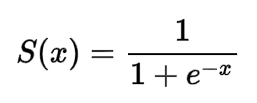

#### Given above is the sigmoid function, which is the function that transforms the initially predicted value (x) to a value constrained within the range [0,1].


#### Let us import the class from the sklearn linear_model module. Then we instantiate an object of the class. 

In [52]:
from sklearn.linear_model import LogisticRegression   # import Logisticregression class from the sklearn linear_model module

In [53]:
log_reg = LogisticRegression()      # instantiate a LogisticRegression object

#### Now we call the fit() method on the training data. This is the step where the model actually "learns" from the data.  

#### Notice how we are passing both the predictor and response variables (X_train_transformed and y_train) to the fit method. In essence, any machine learning model has a set of internal parameters that are optimised in way that the model can make the best predictions.The response variable is shown to the model so that it can update those parameters. 

In [54]:
log_reg.fit(X_train_transformed,y_train)    # fit the model to the training partitions

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### With the training part complete, we can now call the predict() method that is usedto make predictions on unseen data, which will be the test data that we created before. We only pass the predictor variable here so that the model can make predictions using those instrinsic learned parameters.   

In [55]:
log_pred = log_reg.predict(X_test_transformed)    # generate predictions using the test partition

## Performance Metrics: checking how well the model performed.

#### Now that the model has made some predictions, we need some sort of procedure to check how well it performed. This is where performance metrics come in. 

#### For each data instance, essentially 4 cases arise. The model predicted both the classes correctly (True Positive and True negative) and ones where it failed to correctly predict the classes (False Positive and False negative). Different performance metrics help us optimise each of these cases.

####The most commonly used metrics are:

* Accuracy - proportion of all instances correctly classified by the model.   

* Precision - proportion of correctly predicted positive cases out of all the "predicted" positive cases.

* Recall - proportion of correctly predicted cases out of all the "actual" positive cases

* F1 score - This is a combination of precision and recall (harmonic mean of the two).

#### For balanced datasets (data with equal proportion of both classes), accuracy is the appropriate metric to use. 

#### However with imbalanced data (like ours), accuracy falls apart. The disproportionate abundance of one class over another makes the model biased towards that class. Hence even though accuracy might be high, the model is not able to predict the other class instances correctly.

#### It is in such cases that precision and recall come in handy. As a rule of thumb you want to use precision when you care about reducing false positive cases, and recall when you want to reduce false negative cases in your data.

#### Lastly, there are cases where both false psitives and false negatives need to be reduced. The f1 score letsis a suitable metric to achieve that. In our case, we have an imbalanced dataset where both false positives and negatives matter. Hence the F1 score is an appropriate metric for our usecase.

## Confusion Matrix and Classification Report

#### The confusion matrix is a useful matrix that shows us a condensed summary of the 4 cases we discussed earlier. An illustration is shown below:
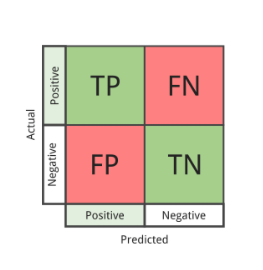

#### Classification report is a more verbose representation of results we obtain from our model. It provides the same information as the matrix but provides a bit more clarity, as it explicitly mentions all the key metrics and quantifies the model's performance.


#### BOth the confusion matrix and the classification report is available in the sklearn.metrics module.

In [56]:
from sklearn.metrics import classification_report, confusion_matrix   # import metrics

#### Note: The support column in the classification report denotes the number of classes in each category, in this case "male" and "female".

In [57]:
print("Confusion matrix: \n",confusion_matrix(y_test,log_pred))
print("Classification report: \n",classification_report(y_test,log_pred))

Confusion matrix: 
 [[261   7]
 [ 92  31]]
Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       268
           1       0.82      0.25      0.39       123

    accuracy                           0.75       391
   macro avg       0.78      0.61      0.61       391
weighted avg       0.76      0.75      0.70       391



#### The logistic regression model gives an accuracy of 75%, precision of 74%, recall = 97% and f1 score of 84%. These kind of discrepancy between the metrics suggests that the data is imbalanced, and the model is biased towards one of the classes, which is true in our case.
 

## Naive Bayes:

#### The Naive Bayes algorithm has its roots in probability theory, and is based on the the Bayes theorem, which is one of the most fundamental parts of probability as a subject. Essentially it lets us update our beliefs by having prior knowledge about an event.

#### The naive bayes classifier does not really learn anything about the data, but operates on top of the probabilities and proportions generated by the data. It also makes a really bold assumption (predictor variables are "conditionally independent" from each other), which is rarely the case in reality. Still it performs really well over problems like text classification or even sentiment analysis. 


#### We can implement naivebayes classifier by using the MultinomialNB class from the naive_bayes module.

In [58]:
from sklearn.naive_bayes import BernoulliNB   # import MultinomialNB class 

#### Now we will follow steps similar to what we did in logistic regression. Instantiate an object, fit the training data and then make predictions on the test data.  There are 3 main types of naive bayes algorithms, the BernoulliNB, the GaussianNB and the MultinomialNB. Each are based on an underlying probability distribution, and are suitable for specific usecases.

#### In our case, we will work with the BernoulliNB.

In [59]:
nb = BernoulliNB()    # instantiate BernoulliNB object

In [60]:
nb.fit(X_train_transformed,y_train)   # fit to the training set

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [61]:
nb_pred = nb.predict(X_test_transformed)    # generate predictions on the test set 

#### Once again we generate performance metrics for the Naive Bayes model.

In [62]:
print("Confusion matrix: \n",confusion_matrix(y_test,nb_pred))
print("Classification report: \n",classification_report(y_test,nb_pred))

Confusion matrix: 
 [[264   4]
 [106  17]]
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.99      0.83       268
           1       0.81      0.14      0.24       123

    accuracy                           0.72       391
   macro avg       0.76      0.56      0.53       391
weighted avg       0.74      0.72      0.64       391



#### We can see that the model has generated pretty good metrics for the "male" class, but not so much for the "female" class. This is because the model operates on probabilities, and in imbalanced datasets the likelihood of getting the rarer class is very low.

## Thus we have used 2 algorithms/models om our data and created a binary text classifier. The metrics can be improved by: 

* Using more data. We can do this by manually imputing the gender values based on their corresponing character_names. This will not only provide us more data but also alleviate the imbalanced dataset problem by having equal proportion of data instances in each class.

* Trying out other classifiers: There are a plethora of classifiers out there to choose from like Decision Trees, Support Vector Machines etc. It is difficult to say which model will perform the best on our data, so there is a lot of trial and error and experimentation associated with a machine learning project.